# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [3]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [3]:
# !pip install xlrd # to be used in pandas 

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [80]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [81]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [82]:
df = pd.merge(df_offers, df_transactions)
df_matrix = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')
df_matrix = df_matrix.fillna(0).reset_index()
df_matrix.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [ ]:
# In K-mean clustering we are more interested in changes in SS and not the magnitude of SS for each K. 
# As K increases, we expect to see changes decrease in SS since we are increasing the number of centriods and 
# the centroids become closer to the group of assigned points (assuming that SS decrease non-monotically wrt k)
# At the begining we will see drastic changes in SS, however as the number of cluster increases 
# the changes in SS expects to decrease and it becomes flatten at certain point (if it decreases non-monotically wrt k).
# Sometimes it’s still hard to figure out a good number of clusters to use because the curve is monotonically decreasing 
# and may not show any elbow or has an obvious point where the curve starts flattening out

In [83]:
x_cols = df_matrix.iloc[:,1:].values

In [84]:
from sklearn.cluster import KMeans

sse = {}
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=100).fit(x_cols)
    sse[k] = kmeans.inertia_
sse

{2: 251.46031746031744,
 3: 227.55739795918367,
 4: 213.23100490196077,
 5: 203.1777777777778,
 6: 194.63853230103228,
 7: 183.80576923076922,
 8: 177.43643724696358,
 9: 169.5477564102564,
 10: 164.2551029107295}

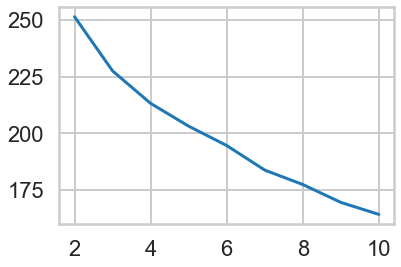

In [85]:
ax = sns.lineplot(x=list(sse.keys()), y=list(sse.values()))

0    39
1    25
2    21
3    15
Name: cluster_k4, dtype: int64


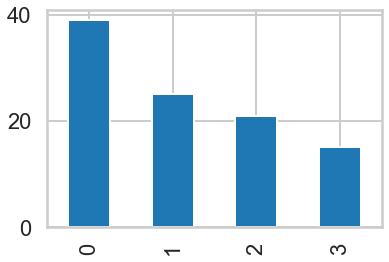

In [112]:
# looking at the magnitude of changes I choose 4 

kmeans_k4 = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=100).fit(x_cols)
df_matrix['cluster_k4'] = kmeans_k4.labels_
df_matrix['cluster_k4'].value_counts().plot(kind='bar')
print(df_matrix['cluster_k4'].value_counts())

In [ ]:
# as mentioned the changes in SS wrt k is monotically decreasing and it is very hard to choose the best K using the elbow method

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

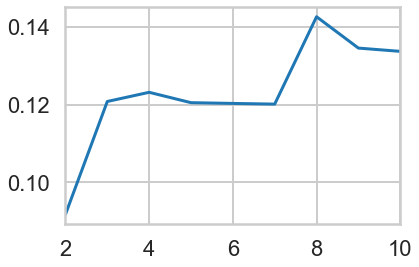

In [113]:
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np

metrics = {}
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=100).fit(x_cols)
    labels =  kmeans.labels_
#     silhout_vals2 = np.mean(silhouette_samples(x_cols, labels)) # this is the same as below
    silhout_vals = silhouette_score(x_cols, labels)
    metrics[k] = [kmeans.inertia_, silhout_vals]

metrics_df = pd.DataFrame(metrics).T
metrics_df.columns = ['SS','Silhouette']
metrics_df['Silhouette'].plot()

# here we can see that all the silhouette score are below 0.15 showing non-substantial structure
# Given the inefficiency of K-mean clustering in this context, I think k=4 still works better based on both metrics
# another alternative can be the k=8 whihch seems a lot given the sampel size

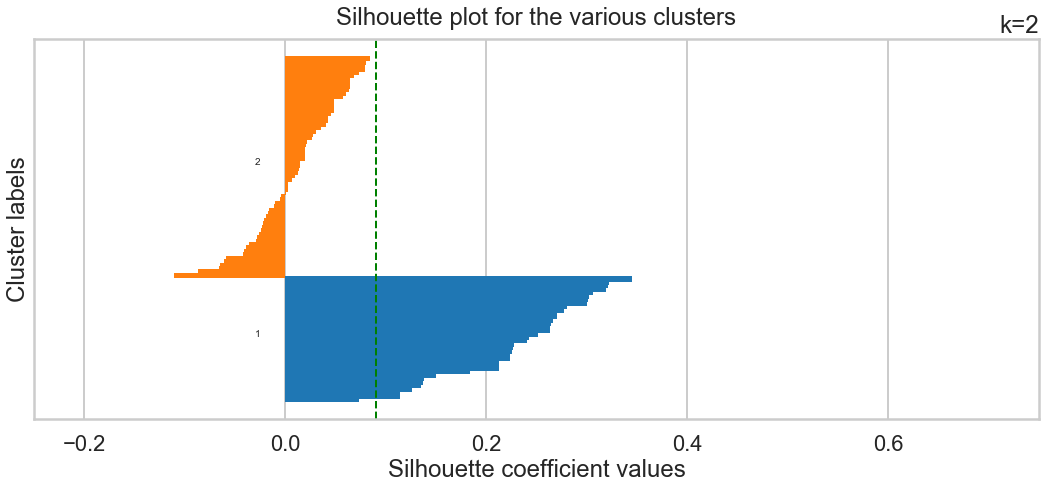

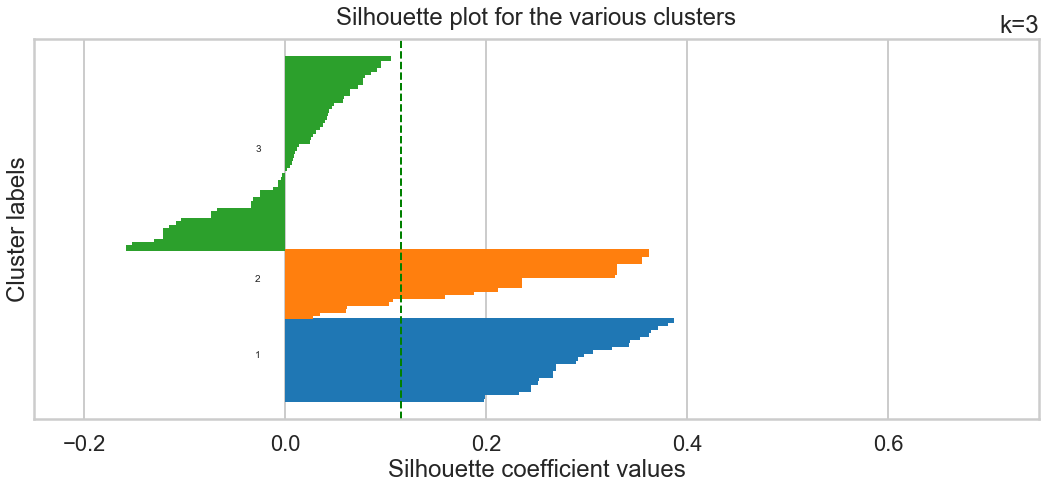

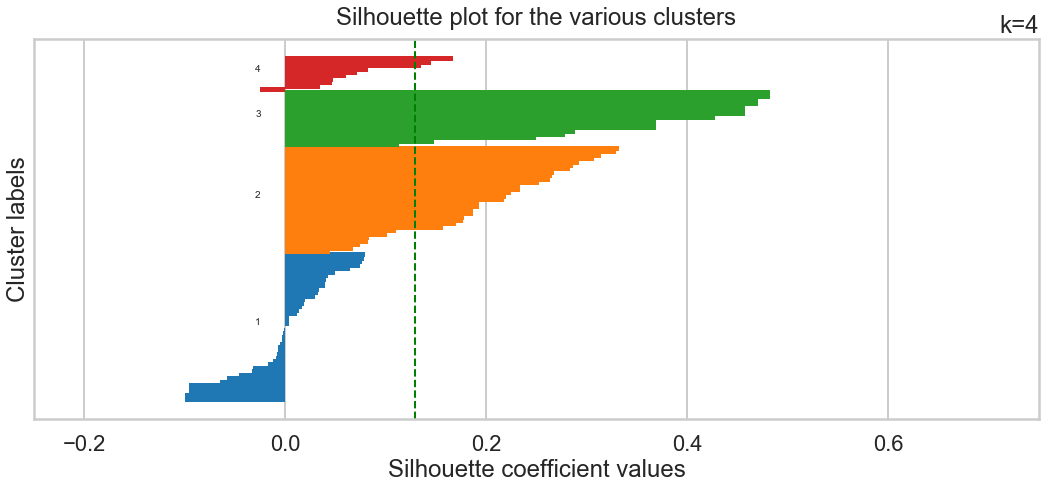

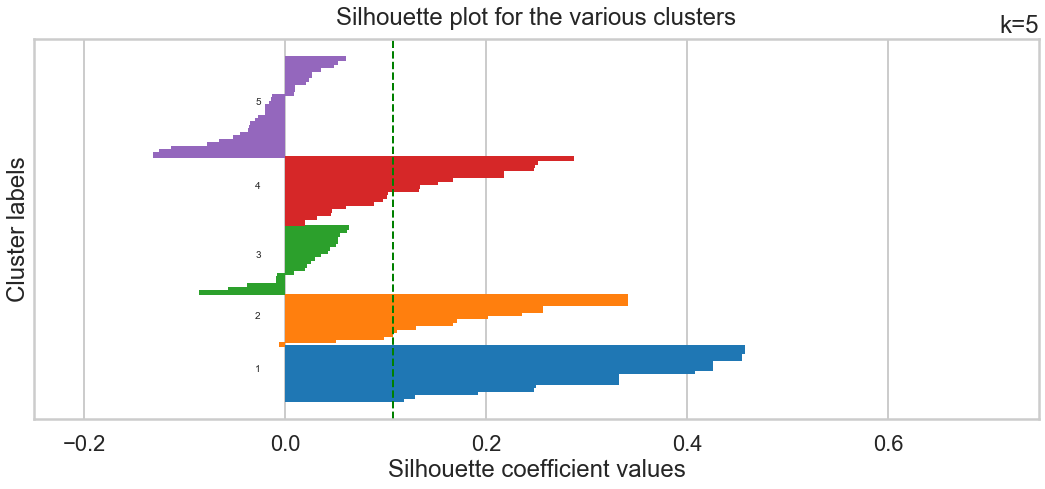

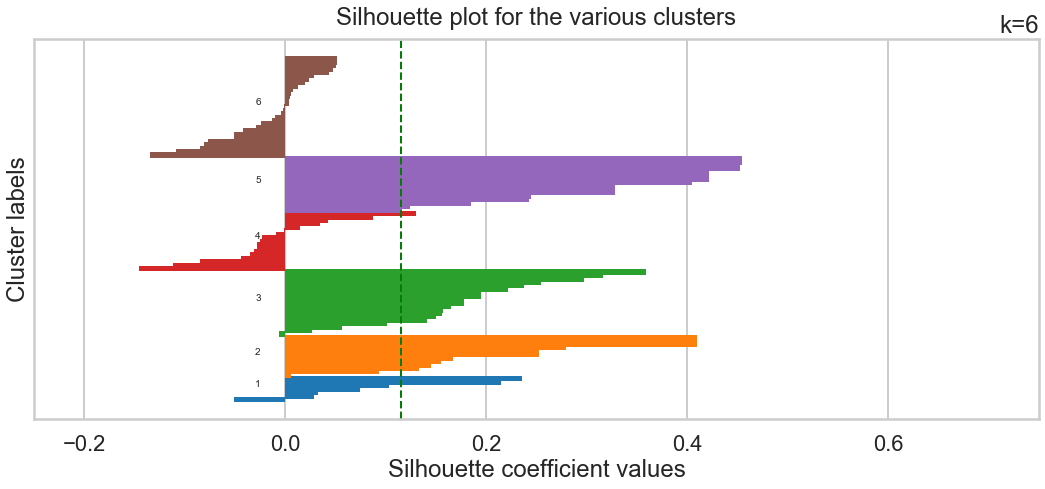

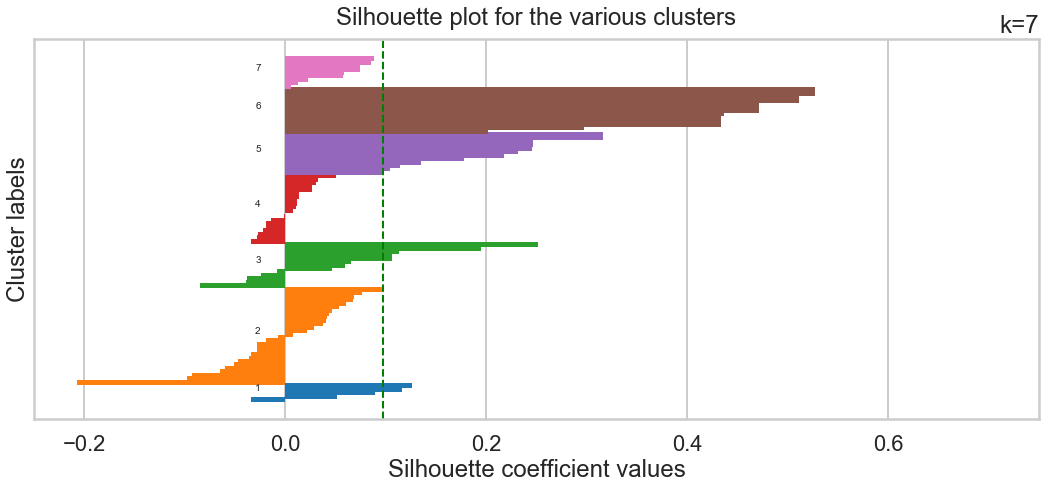

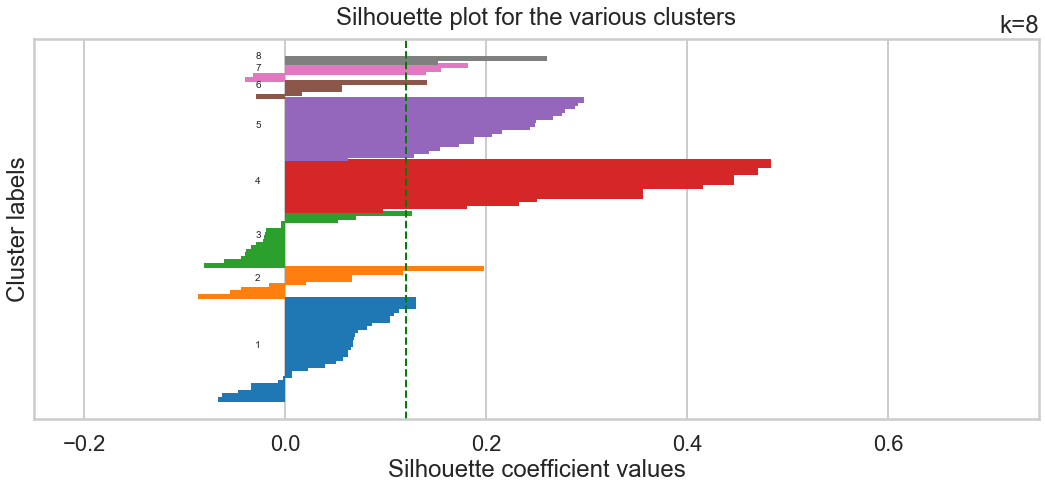

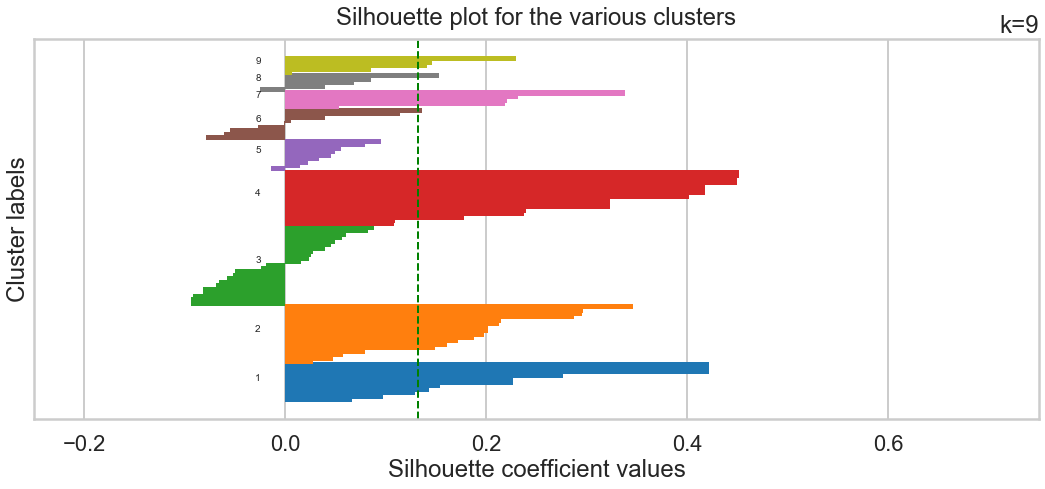

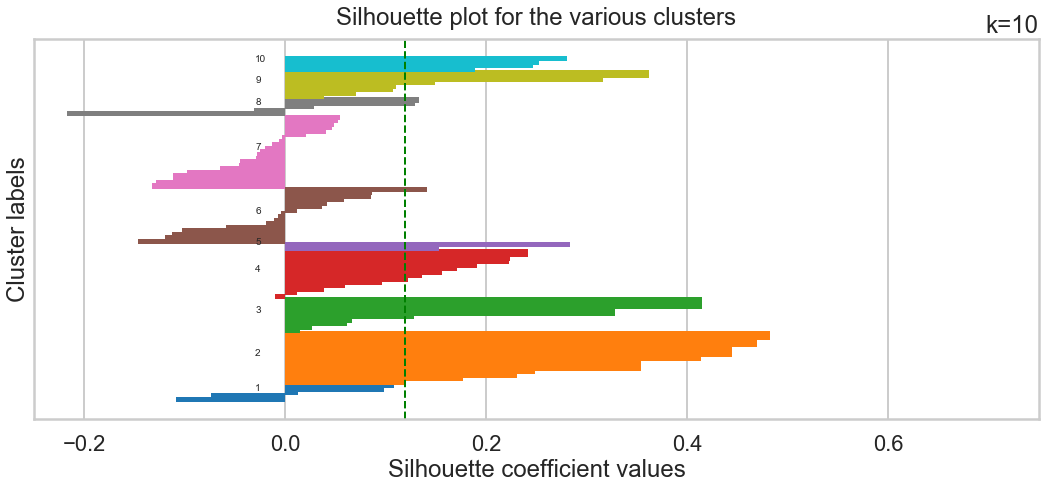

In [114]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

for i, k in enumerate(range(2,11)):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(x_cols)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(x_cols, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1.5)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)
        ax1.set_title(f'k={k}', loc='right')

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-.25, .75])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);

In [137]:
# we also conducted the previous ones on the standardized dataset
from sklearn.preprocessing import StandardScaler

scaler = preprocessing.StandardScaler().fit(x_cols)
x_scaled = scaler.transform(x_cols)

In [153]:
sse_scaled = {}
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=100).fit(x_scaled)
    sse_scaled[k] = kmeans.inertia_
sse_scaled

{2: 2949.377945713509,
 3: 2713.716183813831,
 4: 2539.8129419251,
 5: 2368.493088750658,
 6: 2278.081977949264,
 7: 2141.6974556758328,
 8: 2017.595590090885,
 9: 1929.6772133072982,
 10: 1849.1352537601092}

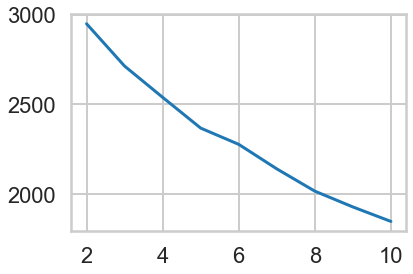

In [154]:
ax = sns.lineplot(x=list(sse_scaled.keys()), y=list(sse_scaled.values()))

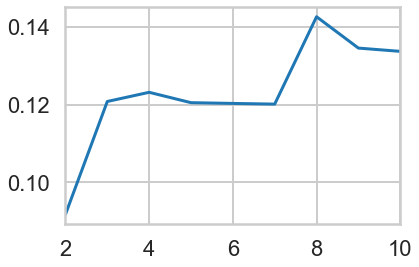

In [155]:
metrics_scaled = {}
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=100).fit(x_scaled)
    labels =  kmeans.labels_
#     silhout_vals2 = np.mean(silhouette_samples(x_cols, labels)) # this is the same as below
    silhout_vals = silhouette_score(x_scaled, labels)
    metrics_scaled[k] = [kmeans.inertia_, silhout_vals]

metrics_scaled_df = pd.DataFrame(metrics).T
metrics_scaled_df.columns = ['SS','Silhouette']
metrics_scaled_df['Silhouette'].plot()

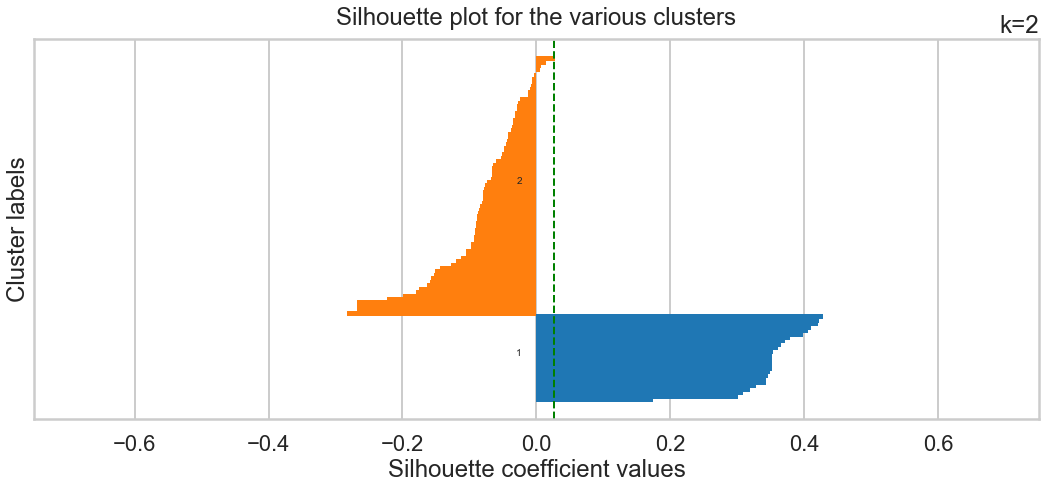

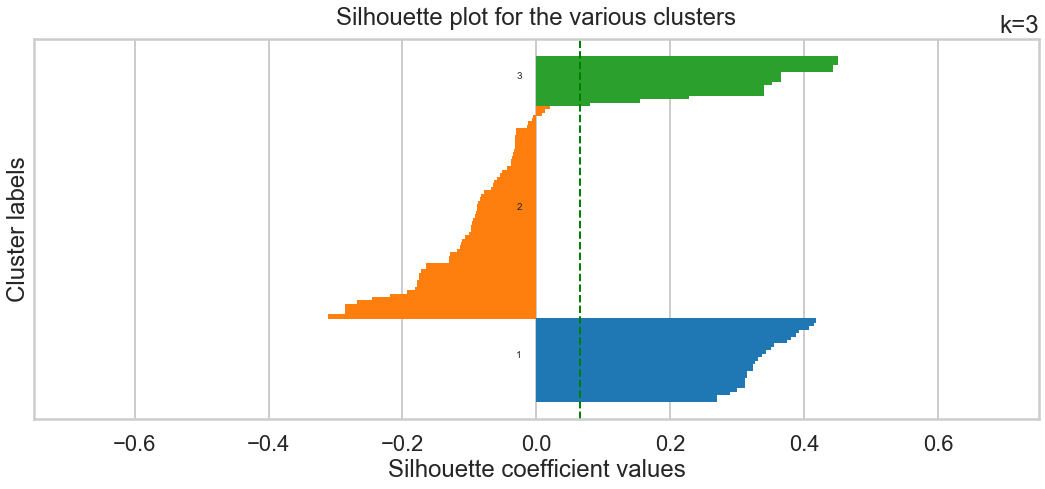

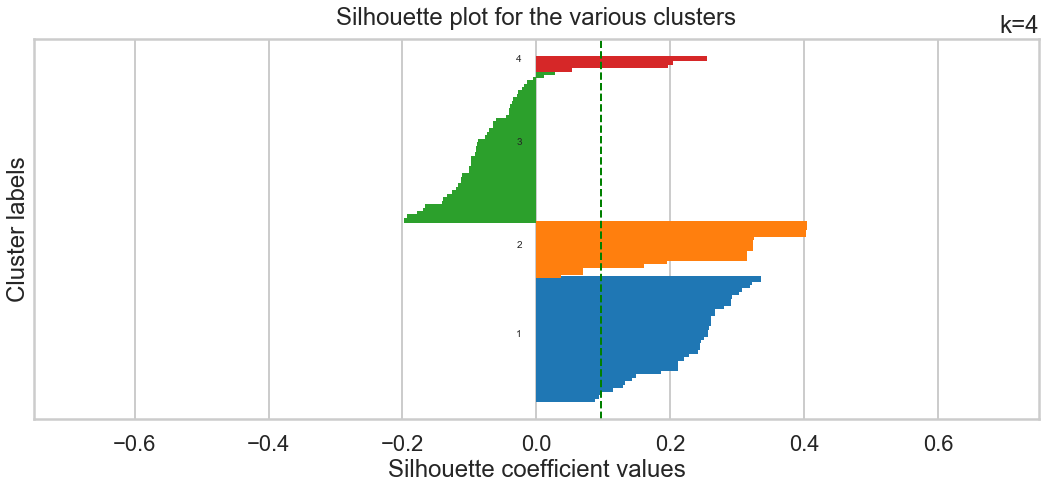

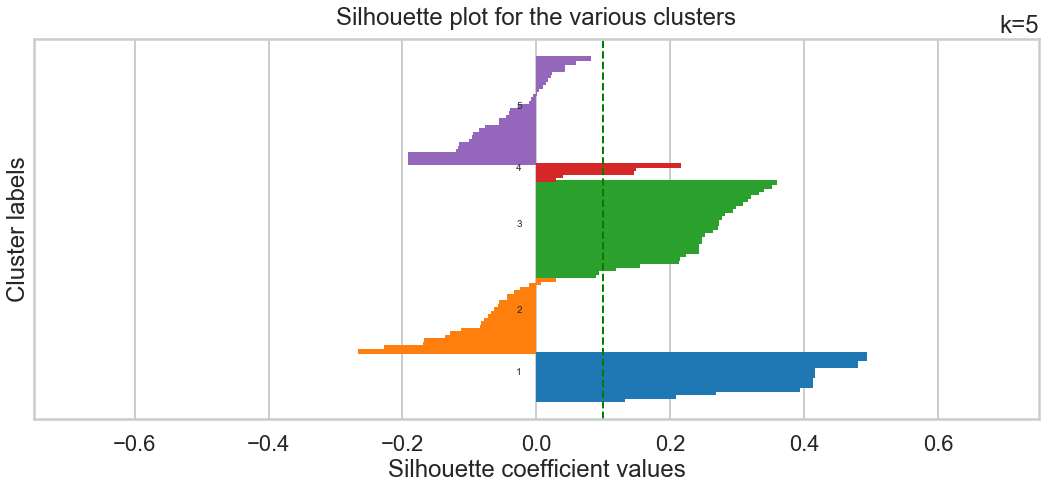

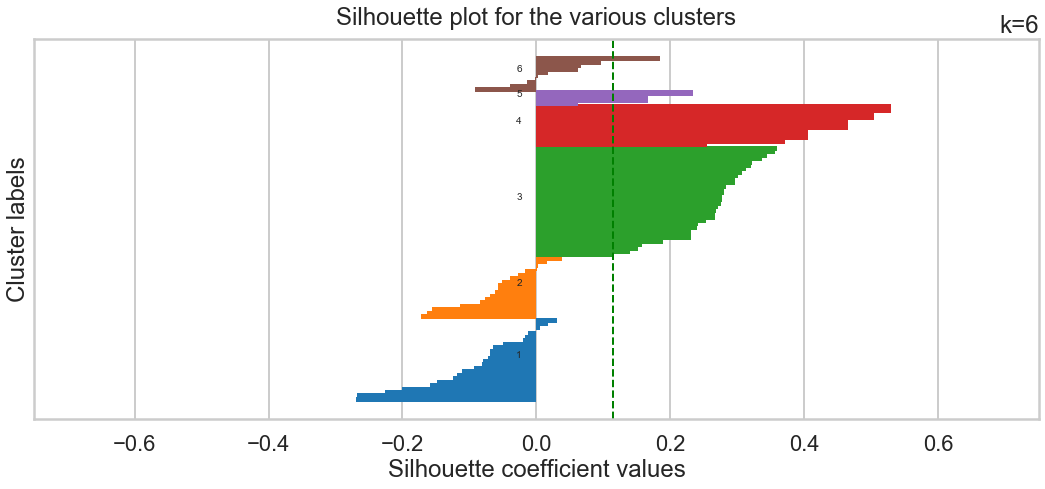

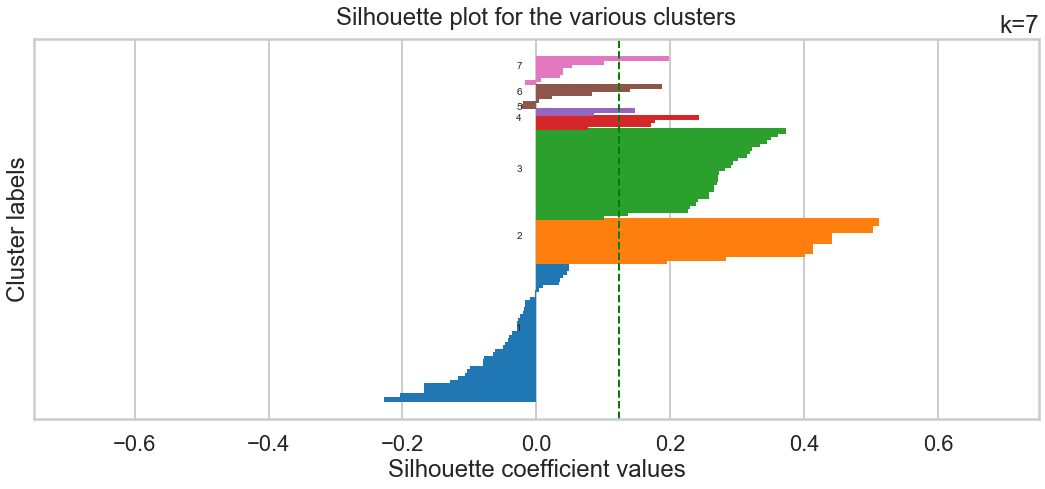

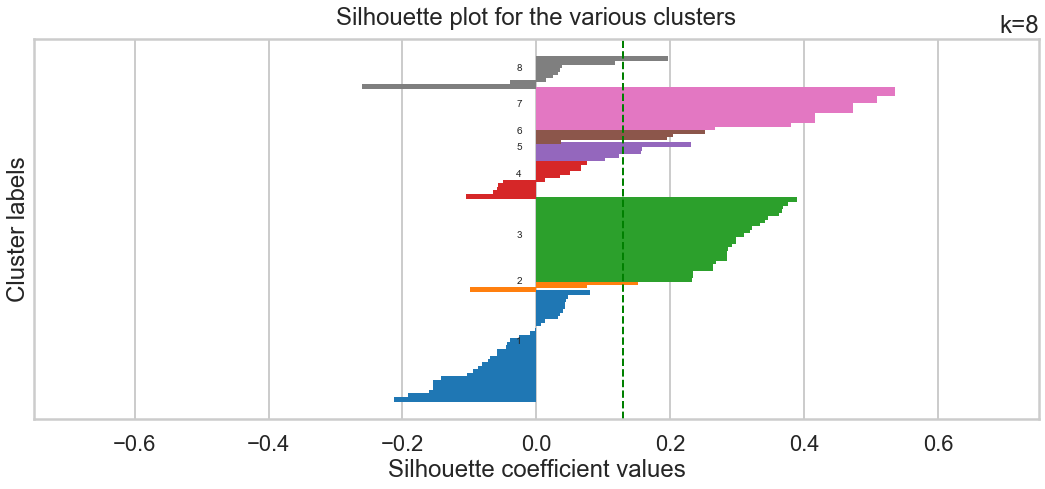

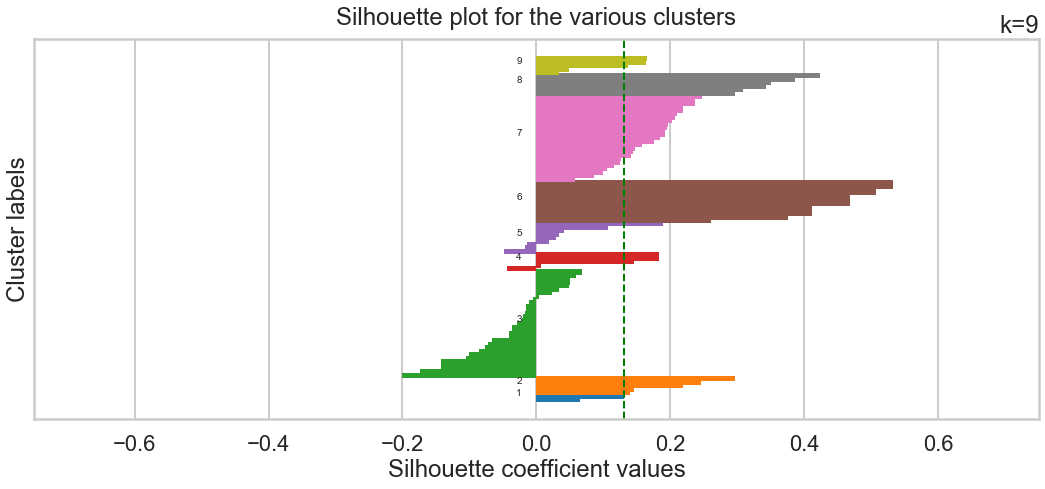

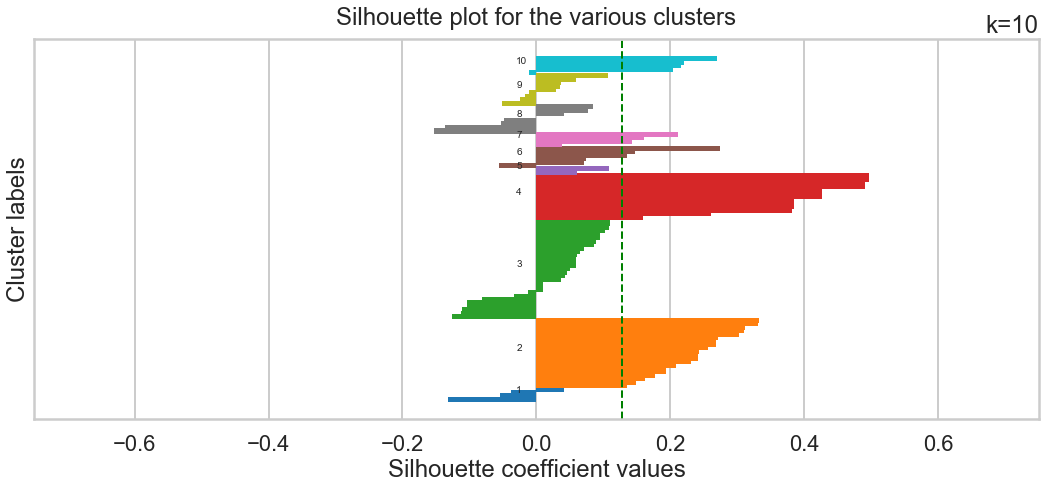

In [157]:
for i, k in enumerate(range(2,11)):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(x_scaled)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(x_scaled, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1.5)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)
        ax1.set_title(f'k={k}', loc='right')

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-.75, .75])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

In [186]:
def optimalK(data, nrefs=2, maxClusters=10):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [196]:
k, gapdf = optimalK(x_cols, nrefs=2, maxClusters=10)
print("Optimal k is: ", k)

Optimal k is:  9


### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [170]:
from sklearn.decomposition import PCA

pca = PCA(copy=True, n_components=2, random_state=42)
principalComponents = pca.fit_transform(x_cols)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [180]:
kmeans_k4 = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=100).fit(x_cols)
df_new = pd.concat([df_matrix[['customer_name', 'cluster_k4']], principalDf], axis=1)
df_new.columns=['customer_name','cluster_k4', 'x','y']

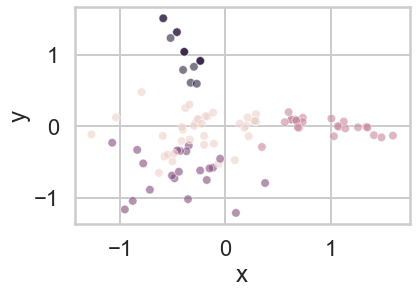

In [185]:
sns.scatterplot(x='x', y='y', hue='cluster_k4', data=df_new, legend=False, size=2, alpha=0.6)
# based on this plot 3 clusters seems to show the pattern better.
# none of the above approaches confirmed what visaully presented in the below figures. 

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

 We need 3 components to explain about 91.94770082321142 of variance in features


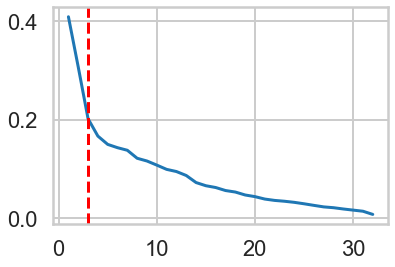

In [253]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

sns.lineplot(x=list(range(1, pca.n_components_+1)), y=list(pca.explained_variance_))
plt.axvline(3, color='red', ls="--")
print(f" We need 3 components to explain about {(pca.explained_variance_[0]+pca.explained_variance_[1]+pca.explained_variance_[2])*100} of variance in features") 

In [431]:
# now to show the 3D graph of how clusters look like for 3 components PCAs

pca_3 = PCA(copy=True, n_components=3, random_state=42)
pca_3 = pca_3.fit_transform(x_cols)
pca_3_df = pd.DataFrame(data = pca_3, 
                        columns = ['pca_3_1', 'pca_3_2', 'pca_3_3'])

df_pca3 = pd.concat([df_matrix[['customer_name', 'cluster_k4']], pca_3_df], axis=1)
df_pca3.head()

,customer_name,cluster_k4,pca_3_1,pca_3_2,pca_3_3
0,Adams,1,1.007580,0.108215,0.545614
1,Allen,0,-0.287539,0.044715,-0.044072
2,Anderson,3,-0.392032,1.038391,-0.266342
3,Bailey,1,0.699477,-0.022542,0.133556
4,Baker,0,0.088183,-0.471695,-0.777541


Text(0.5, 0, 'component 3')

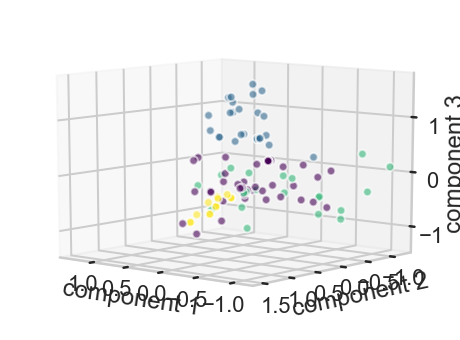

In [447]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')


xs= df_pca3['pca_3_3']
ys= df_pca3['pca_3_2']
zs= df_pca3['pca_3_1']
c = df_pca3['cluster_k4']
ax.scatter(xs, ys, zs, c=c, s=70, cmap='viridis', alpha=0.6, edgecolors='w')
ax.view_init(elev=10., azim=130) # changing the position of camera
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set_zlabel('component 3')

# looking at 3d plot we can discuss how different clusters are different from each others

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


Silhouette Coefficient: 0.18


C:\Users\Farzad\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


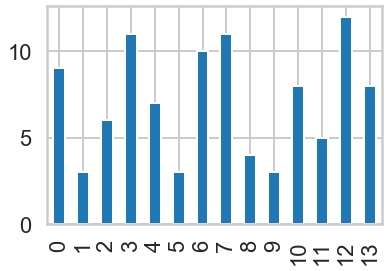

In [410]:
#Affinity propagation
from sklearn.cluster import AffinityPropagation

affinity = AffinityPropagation(damping=0.5).fit(x_cols)

affinity.cluster_centers_indices_ # cluster centers indices (exampler index)
labels = pd.DataFrame(affinity.labels_)
labels.columns=['affinity']
labels.affinity.value_counts().sort_index().plot(kind='bar')
labels.affinity.value_counts().sort_index()

print(f"Silhouette Coefficient: {round(metrics.silhouette_score(x_cols, labels, metric='sqeuclidean'),2)}")

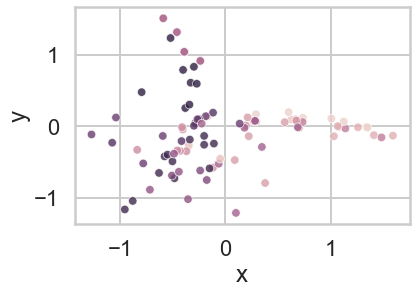

In [411]:
# visualizing the result over the two components

df_kmean['affinity'] = affinity.labels_
sns.scatterplot(x='x', y='y', hue='affinity', data=df_kmean, legend=False, size=2, alpha=0.8)

0    100
Name: mean_shift, dtype: int64

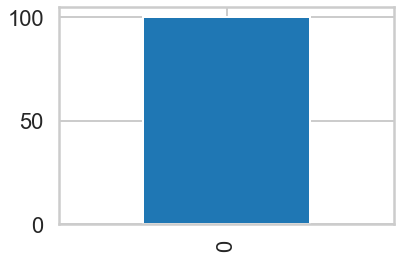

In [311]:
# Using mean shift
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(x_cols, quantile=.3)
ms = MeanShift(bin_seeding=True, cluster_all=True).fit(x_cols)
labels = pd.DataFrame(ms.labels_)
labels.columns=['mean_shift']
labels.mean_shift.value_counts().sort_index().plot(kind='bar')
labels.mean_shift.value_counts().sort_index()

# print(f"Silhouette Coefficient: {round(metrics.silhouette_score(x_cols, labels, metric='sqeuclidean'),2)}")

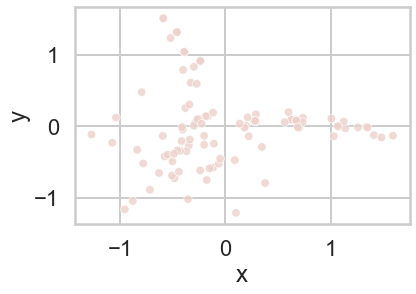

In [412]:
df_kmean['meanshift'] = ms.labels_
sns.scatterplot(x='x', y='y', hue='meanshift', data=df_kmean, legend=False, size=2, alpha=0.8)

Silhouette Coefficient: 0.17


C:\Users\Farzad\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


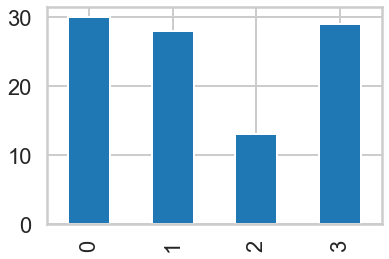

In [414]:
# Using Spectral Clustering
from sklearn.cluster import SpectralClustering

spectral_clustering = SpectralClustering(n_clusters= 4, assign_labels='kmeans', n_init=100, affinity='nearest_neighbors').fit(x_cols)
labels = pd.DataFrame(spectral_clustering.labels_)
labels.columns=['spectral']
labels.spectral.value_counts().sort_index().plot(kind='bar')
labels.spectral.value_counts().sort_index()

print(f"Silhouette Coefficient: {round(metrics.silhouette_score(x_cols, labels, metric='sqeuclidean'),2)}")

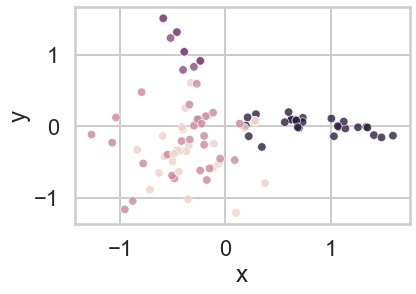

In [415]:
df_kmean['spectral'] = spectral_clustering.labels_
sns.scatterplot(x='x', y='y', hue='spectral', data=df_kmean, legend=False, size=2, alpha=0.8)

Silhouette Coefficient: 0.08


C:\Users\Farzad\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


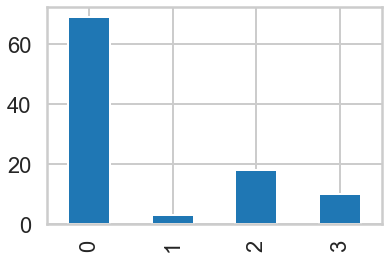

In [416]:
# using agglomerative clustering
from sklearn.cluster import AgglomerativeClustering

agg_cluster = AgglomerativeClustering(n_clusters=4,  affinity='l2', linkage='complete').fit(x_cols)
labels = pd.DataFrame(agg_cluster.labels_)
labels.columns=['agg_clustering']
labels.agg_clustering.value_counts().sort_index().plot(kind='bar')
labels.agg_clustering.value_counts().sort_index()

print(f"Silhouette Coefficient: {round(metrics.silhouette_score(x_cols, labels, metric='sqeuclidean'),2)}")

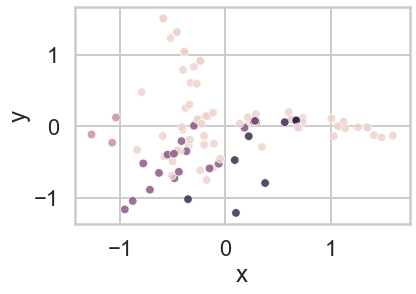

In [417]:
df_kmean['agglomerative'] = agg_cluster.labels_
sns.scatterplot(x='x', y='y', hue='agglomerative', data=df_kmean, legend=False, size=2, alpha=0.8)

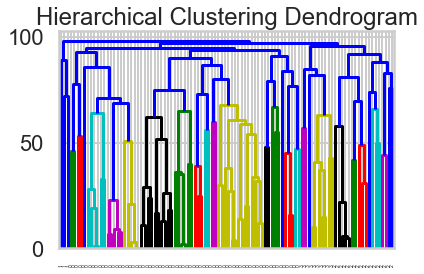

In [418]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plot_dendrogram(agg_cluster, labels=agg_cluster.labels_)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

-1    56
 0    26
 1    14
 2     4
Name: dbscan, dtype: int64

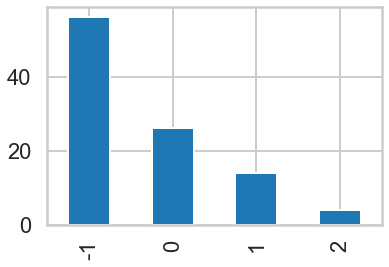

In [381]:
# DBSCAN
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.4,  min_samples=4).fit(x_cols)
labels = pd.DataFrame(dbscan.labels_)
labels.columns=['dbscan']
labels.dbscan.value_counts().sort_index().plot(kind='bar')
labels.dbscan.value_counts().sort_index()

# print(f"Silhouette Coefficient: {round(metrics.silhouette_score(x_cols, labels, metric='sqeuclidean'),2)}")
# very sensetive to eps value (-1 is noise)

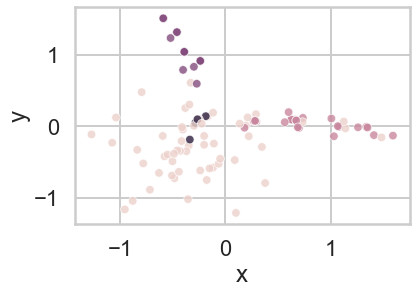

In [423]:
df_kmean['dbscan'] = dbscan.labels_
sns.scatterplot(x='x', y='y', hue='dbscan', data=df_kmean, legend=False, size=2, alpha=0.8)

Silhouette Coefficient: 0.05


C:\Users\Farzad\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


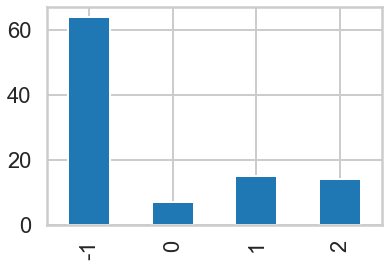

In [388]:
# OPTICS (relax the eps requirement from a value to a range)
from sklearn.cluster import OPTICS

optics = OPTICS(min_samples = 5, max_eps=2).fit(x_cols)

labels = pd.DataFrame(optics.labels_)
labels.columns=['optics']
labels.optics.value_counts().sort_index().plot(kind='bar')
labels.optics.value_counts().sort_index()

print(f"Silhouette Coefficient: {round(metrics.silhouette_score(x_cols, labels, metric='sqeuclidean'),2)}")

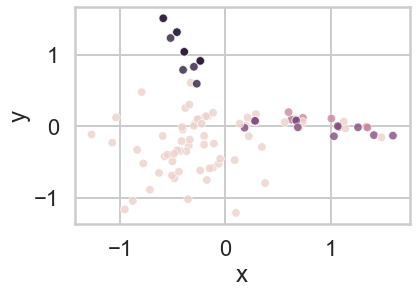

In [424]:
df_kmean['optics'] = optics.labels_
sns.scatterplot(x='x', y='y', hue='optics', data=df_kmean, legend=False, size=2, alpha=0.8)

Silhouette Coefficient: 0.16


C:\Users\Farzad\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


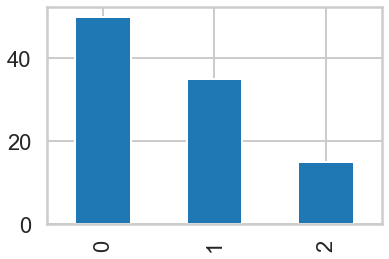

In [396]:
# Birch
from sklearn.cluster import Birch

birch = Birch(threshold=0.01, branching_factor=30).fit(x_cols)
labels = pd.DataFrame(birch.labels_)
labels.columns=['birch']
labels.birch.value_counts().sort_index().plot(kind='bar')
labels.birch.value_counts().sort_index()

print(f"Silhouette Coefficient: {round(metrics.silhouette_score(x_cols, labels, metric='sqeuclidean'),2)}")

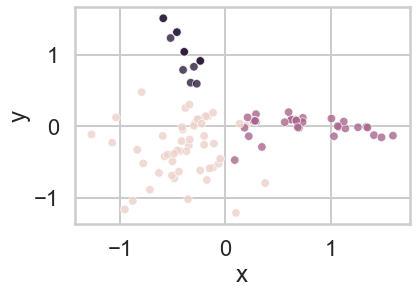

In [425]:
df_kmean['birch'] = birch.labels_
sns.scatterplot(x='x', y='y', hue='birch', data=df_kmean, legend=False, size=2, alpha=0.8)

In [ ]:
# tell the story here
# Overall, the result of clustering seems to be signifantly different depending on the chosen methods. 

In [ ]:
# # other comparison can be based on ... (assuming that )
# # af = AffinityPropagation(preference=-50).fit(X)
# cluster_centers_indices = af.cluster_centers_indices_
# labels = af.labels_

# n_clusters_ = len(cluster_centers_indices)

# print('Estimated number of clusters: %d' % n_clusters_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels,
#                                            average_method='arithmetic'))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels, metric='sqeuclidean'))
